<a href="https://colab.research.google.com/github/puni-ram48/DL-Reg-implementation-/blob/feature/L2Vs_DLreg_when_gamma_%3D0_0001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3669 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3680
    })
    test: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3669
    })
})


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 166MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 87.8MB/s]


Epoch 1/30, Train Acc: 0.03226902173913043, Val Acc: 0.07201086956521739, Test Acc: 0.0771327337149087
Epoch 2/30, Train Acc: 0.29721467391304346, Val Acc: 0.5801630434782609, Test Acc: 0.6271463614063778
Epoch 3/30, Train Acc: 0.7992527173913043, Val Acc: 0.8097826086956521, Test Acc: 0.8288361951485419
Epoch 4/30, Train Acc: 0.9021739130434783, Val Acc: 0.8315217391304348, Test Acc: 0.860452439356773
Epoch 5/30, Train Acc: 0.9480298913043478, Val Acc: 0.8858695652173912, Test Acc: 0.8926137912237667
Epoch 6/30, Train Acc: 0.9646739130434783, Val Acc: 0.9076086956521738, Test Acc: 0.9043336058871627
Epoch 7/30, Train Acc: 0.9728260869565217, Val Acc: 0.8926630434782609, Test Acc: 0.8931588988825293
Epoch 8/30, Train Acc: 0.9864130434782609, Val Acc: 0.9089673913043478, Test Acc: 0.9062414826928319
Epoch 9/30, Train Acc: 0.991508152173913, Val Acc: 0.9184782608695652, Test Acc: 0.9056963750340693
Epoch 10/30, Train Acc: 0.9976222826086957, Val Acc: 0.9266304347826086, Test Acc: 0.90869

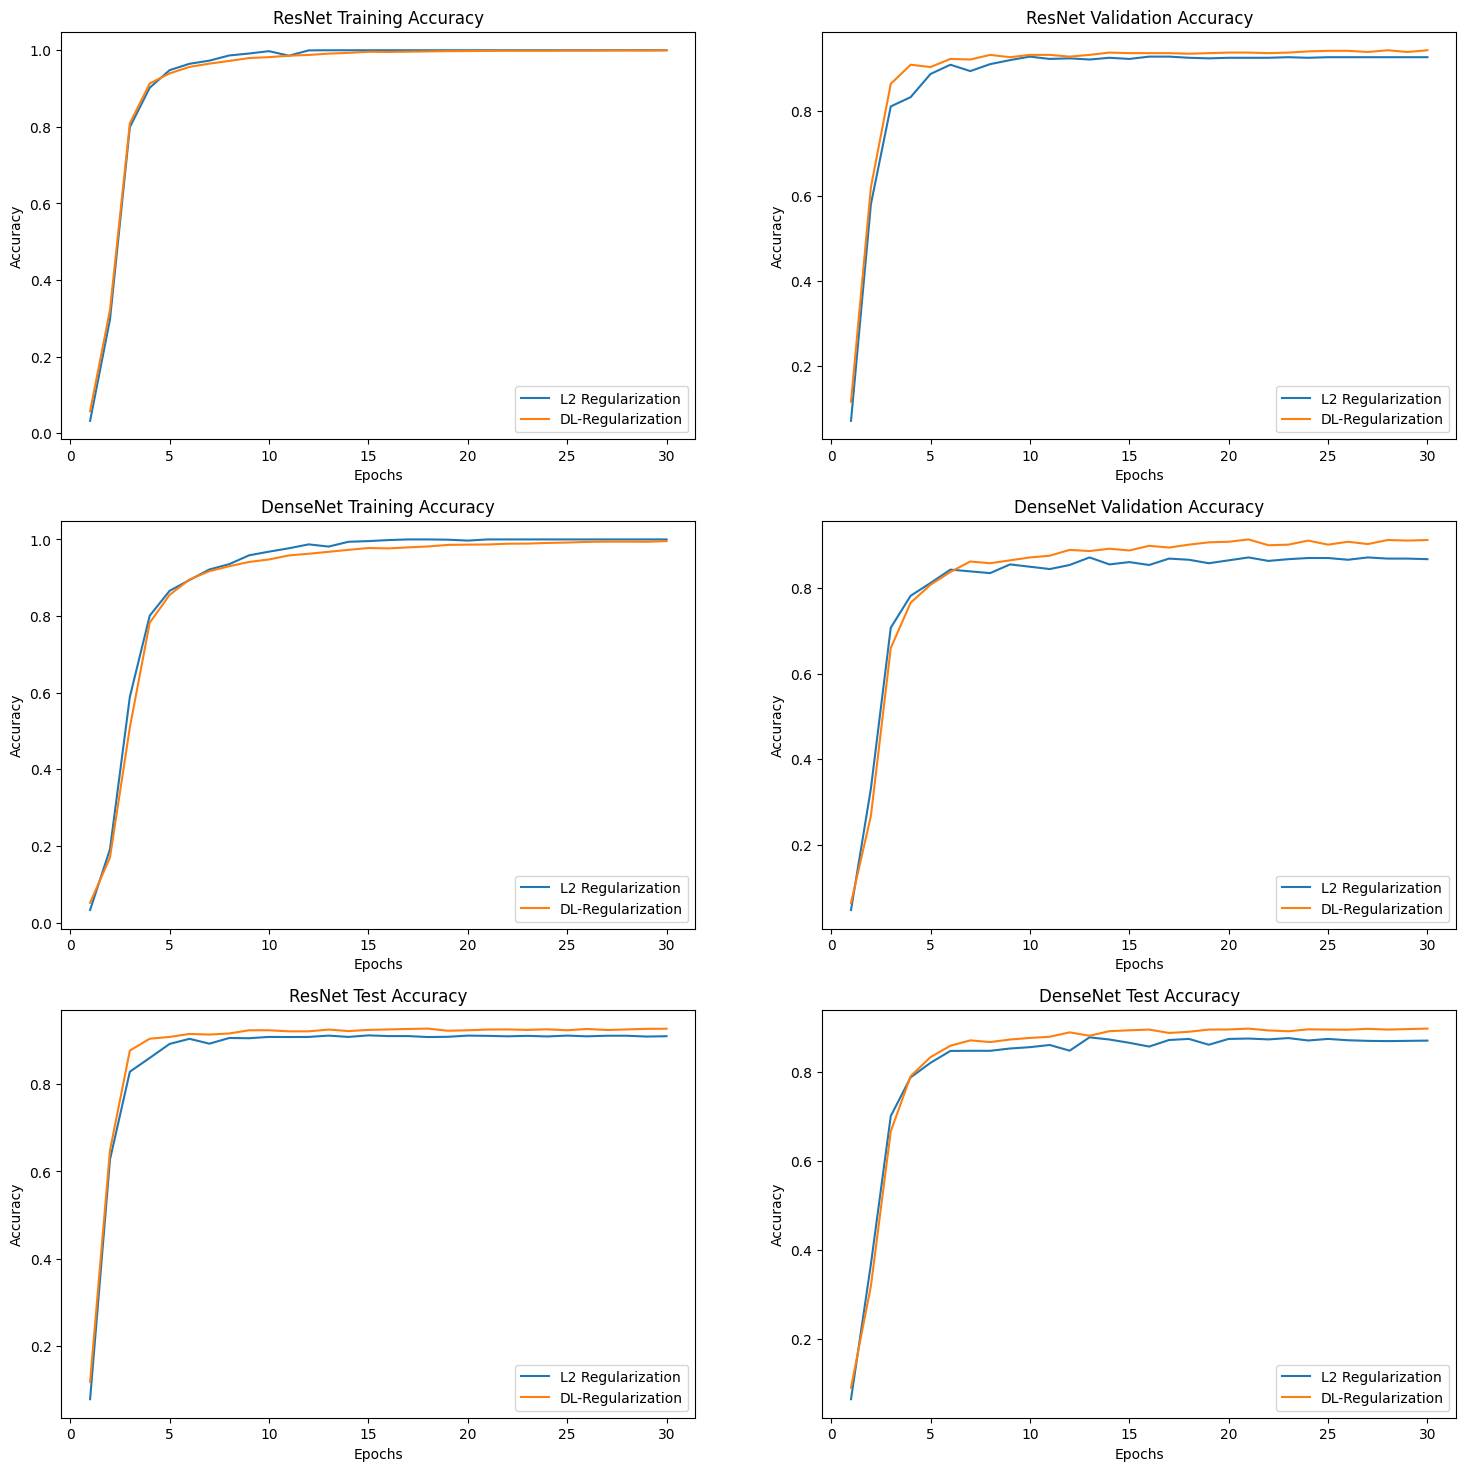

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Define constants
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

# Load the Oxford-IIIT Pet dataset from Hugging Face
dataset = load_dataset('timm/oxford-iiit-pet')

# Print the dataset structure to check available splits
print(dataset)

# Identify the correct splits
train_split = 'train'
test_split = 'test'

# Custom dataset class to handle Hugging Face dataset
class OxfordIIITPetDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations for the Oxford-IIIT Pet dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode != "RGB" else x),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare the dataset and dataloaders
train_val_dataset = OxfordIIITPetDataset(dataset[train_split], transform=transform)
test_dataset = OxfordIIITPetDataset(dataset[test_split], transform=transform)

# Split the train dataset into train and validation sets
train_size = int((1 - VALIDATION_SPLIT) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the models with updated weights parameter
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Modify the final layers to fit Oxford-IIIT Pet classes (37 classes)
num_ftrs_resnet = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs_resnet, 37)

num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)

# Define DL-Regularization
class DLRegularization(nn.Module):
    def __init__(self, model, lambda_reg=0.0001):
        super(DLRegularization, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg

    def forward(self, x):
        output = self.model(x)
        return output

    def dl_reg_loss(self, x, output):
        batch_size = x.size(0)
        Z = nn.Linear(x.view(batch_size, -1).size(1), output.size(1), bias=False).to(x.device)
        reg_loss = torch.norm(Z(x.view(batch_size, -1)) - output) ** 2
        return self.lambda_reg * reg_loss

# Training function
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS, dl_regularizer=None):
    model.train()
    train_acc = []
    val_acc = []
    test_acc = []

    for epoch in range(num_epochs):
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if dl_regularizer:
                reg_loss = dl_regularizer.dl_reg_loss(inputs, outputs)
                loss += reg_loss

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(train_dataset)
        train_acc.append(epoch_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_acc.append(epoch_val_acc.item())

        # Test
        test_corrects = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

        epoch_test_acc = test_corrects.double() / len(test_dataset)
        test_acc.append(epoch_test_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {epoch_acc.item()}, Val Acc: {epoch_val_acc.item()}, Test Acc: {epoch_test_acc.item()}')

    return train_acc, val_acc, test_acc

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment with L2 regularization on ResNet
resnet152 = resnet152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet152.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
train_acc_l2_resnet, val_acc_l2_resnet, test_acc_l2_resnet = train_model(resnet152, criterion, optimizer)

# Experiment with DL-Regularization on ResNet
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
num_ftrs_resnet = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs_resnet, 37)
resnet152 = resnet152.to(device)
optimizer = optim.SGD(resnet152.parameters(), lr=LEARNING_RATE)
dl_regularizer = DLRegularization(resnet152, lambda_reg=0.0001)
train_acc_dl_resnet, val_acc_dl_resnet, test_acc_dl_resnet = train_model(resnet152, criterion, optimizer, dl_regularizer=dl_regularizer)

# Experiment with L2 regularization on DenseNet
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)
densenet = densenet.to(device)
optimizer = optim.SGD(densenet.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
train_acc_l2_densenet, val_acc_l2_densenet, test_acc_l2_densenet = train_model(densenet, criterion, optimizer)

# Experiment with DL-Regularization on DenseNet
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)
densenet = densenet.to(device)
optimizer = optim.SGD(densenet.parameters(), lr=LEARNING_RATE)
dl_regularizer = DLRegularization(densenet, lambda_reg=0.0001)
train_acc_dl_densenet, val_acc_dl_densenet, test_acc_dl_densenet = train_model(densenet, criterion, optimizer, dl_regularizer=dl_regularizer)

# Plotting the results
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
plt.plot(epochs, train_acc_l2_resnet, label='L2 Regularization')
plt.plot(epochs, train_acc_dl_resnet, label='DL-Regularization')
plt.title('ResNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs, val_acc_l2_resnet, label='L2 Regularization')
plt.plot(epochs, val_acc_dl_resnet, label='DL-Regularization')
plt.title('ResNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(epochs, train_acc_l2_densenet, label='L2 Regularization')
plt.plot(epochs, train_acc_dl_densenet, label='DL-Regularization')
plt.title('DenseNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epochs, val_acc_l2_densenet, label='L2 Regularization')
plt.plot(epochs, val_acc_dl_densenet, label='DL-Regularization')
plt.title('DenseNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(epochs, test_acc_l2_resnet, label='L2 Regularization')
plt.plot(epochs, test_acc_dl_resnet, label='DL-Regularization')
plt.title('ResNet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epochs, test_acc_l2_densenet, label='L2 Regularization')
plt.plot(epochs, test_acc_dl_densenet, label='DL-Regularization')
plt.title('DenseNet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [4]:
def calculate_accuracy(accuracy_list):
    final_accuracy = accuracy_list[-1] * 100
    return final_accuracy

# Calculate test accuracies
test_acc_l2_resnet_pct = calculate_accuracy(test_acc_l2_resnet)
test_acc_dl_resnet_pct = calculate_accuracy(test_acc_dl_resnet)
test_acc_l2_densenet_pct = calculate_accuracy(test_acc_l2_densenet)
test_acc_dl_densenet_pct = calculate_accuracy(test_acc_dl_densenet)

# Print test accuracies
print(f'Test Accuracy of ResNet with L2 Regularization: {test_acc_l2_resnet_pct:.2f}%')
print(f'Test Accuracy of ResNet with DL-Regularization: {test_acc_dl_resnet_pct:.2f}%')
print(f'Test Accuracy of DenseNet with L2 Regularization: {test_acc_l2_densenet_pct:.2f}%')
print(f'Test Accuracy of DenseNet with DL-Regularization: {test_acc_dl_densenet_pct:.2f}%')

Test Accuracy of ResNet with L2 Regularization: 91.03%
Test Accuracy of ResNet with DL-Regularization: 92.75%
Test Accuracy of DenseNet with L2 Regularization: 87.08%
Test Accuracy of DenseNet with DL-Regularization: 89.78%
